In [13]:
import pandas as pd
import numpy as np
import re

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

# stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# nltk 停用词与情绪辞典
# import nltk
# nltk.download('stopwords') # Error loading SSL Web issue
# from nltk.corpus import stopwords

In [5]:
# Clean
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 移除 @用户名 和 长数字ID
    text = re.sub(r'@\w+|\d{5,}', '', text)
    # 移除网址
    text = re.sub(r'http\S+|www\S+', '', text)
    # 移除标点符号（如果对任务无关）
    text = re.sub(r'[^\w\s]', '', text)
    # 多余空格压缩
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [27]:
# df = pd.read_csv("assets/clean_sample_for_labeling.csv")
df = pd.read_csv("assets/labeled_200_dataset.csv")
df.head()

,text,label
0,We have a week to travel suggestions Pefer war...,other_uncategorized
1,Wärst du stattdessen auch mit der Böhmischen S...,other_chitchat
2,Then stop sending them to my Private Sprint nu...,other_uncategorized
3,Para cuando las 3as temporadas de Mr Robot y M...,other_uncategorized
4,Dear my apologies for the strong language last...,other_language_issues


In [6]:
# 清洗原始数据
df_all = pd.read_csv("datasets/twcs.csv")
df_all["cleaned_text"] = df_all["text"].apply(clean_text)
df_all = df_all[df_all["cleaned_text"].str.strip() != ""]
df_all[["text", "cleaned_text"]].head()

,text,cleaned_text
0,@115712 I understand. I would like to assist y...,I understand I would like to assist you We wou...
1,@sprintcare and how do you propose we do that,and how do you propose we do that
2,@sprintcare I have sent several private messag...,I have sent several private messages and no on...
3,@115712 Please send us a Private Message so th...,Please send us a Private Message so that we ca...
4,@sprintcare I did.,I did


In [41]:
# 模型训练

# 载入标注数据
# df_labeled = pd.read_csv("assets/clean_sample_for_labeling.csv")
df_labeled = pd.read_csv("assets/labeled_200_dataset.csv")

# 再次清洗文本
df_labeled["cleaned_text"] = df_labeled["text"].astype(str).apply(clean_text)

# 去除空标签，空文本
df_labeled = df_labeled[df_labeled["label"].notnull()]
df_labeled = df_labeled[df_labeled["cleaned_text"].str.strip() != ""]

# 构建平衡训练集
balanced_df = (df_labeled.groupby("label", group_keys=False)
               .apply(lambda x: x.sample(n=min(len(x), 50),random_state=42)).reset_index(drop=True))
balanced_df = balanced_df.groupby("label", group_keys=False).filter(lambda x: len(x) >= 2)

X_test = balanced_df["cleaned_text"]
y = balanced_df["label"]

# TF-IDF
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(X_test)
# X = vectorizer.fit_transform(df_labeled["cleaned_text"])

# 对 df_all 中的 cleaned_text 进行预测
# X_all = vectorizer.fit_transform(df_all["cleaned_text"])

# 训练逻辑（简单逻辑回归）
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

print("OK")

OK


/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_32381/1035664142.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 50),random_state=42)).reset_index(drop=True))


In [40]:
# print(X.shape[1])

2163


In [39]:
# df_all["cleaned_text"] = df_all["text"].apply(clean_text)
# X_all = vectorizer.transform(df_all["cleaned_text"])
# print(X_all.shape[1])

# 预测
# df_all["risk_label"] = model.predict(X_all)

3000


In [42]:
# 分训练/验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
# 训练 MLP 多层感知器
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64),
                          max_iter=500,
                          random_state=42,
                          )
# mlp_model.fit(X_train, y_train)
mlp_model.fit(X, y)
df_all["cleaned_text"] = df_all["text"].astype(str).apply(clean_text)
X_all = vectorizer.transform(df_all["cleaned_text"])
df_all["risk_label"] = mlp_model.predict(X_all)

# 准确率评估
y_pred = mlp_model.predict(X_val)
print(classification_report(y_val, y_pred))
print(df_all[["text", "risk_label"]].head())
print("✅ 多层感知器模型训练完成")

                        precision    recall  f1-score   support

               account       1.00      1.00      1.00         2
              delivery       1.00      1.00      1.00         2
        other_chitchat       1.00      1.00      1.00        10
other_general_question       1.00      1.00      1.00         4
   other_uncategorized       1.00      1.00      1.00        10
               payment       1.00      1.00      1.00         2
               service       1.00      1.00      1.00         1
             technical       1.00      1.00      1.00         1

              accuracy                           1.00        32
             macro avg       1.00      1.00      1.00        32
          weighted avg       1.00      1.00      1.00        32

                                                text           risk_label
0  @115712 I understand. I would like to assist y...       other_chitchat
1      @sprintcare and how do you propose we do that  other_uncategorized
2  @spr

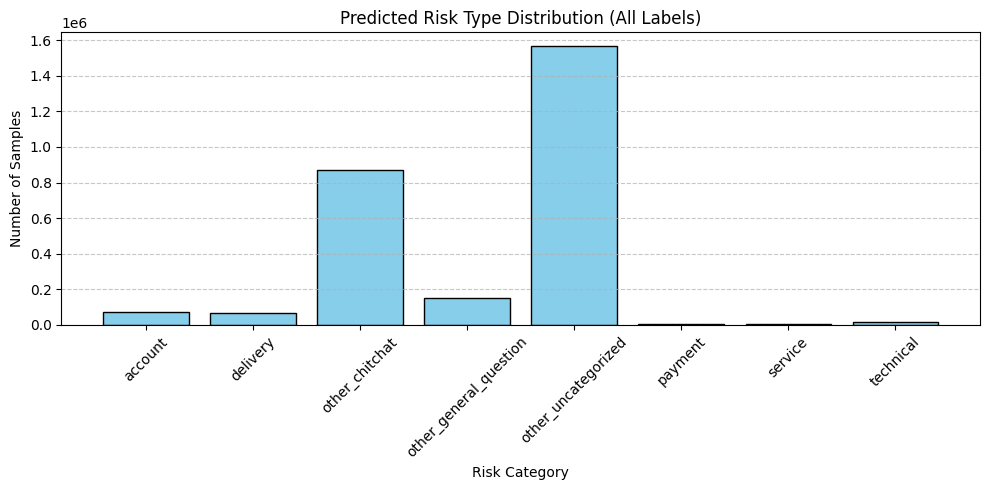

In [44]:
import matplotlib.pyplot as plt

# 预定义的所有标签（手动写上完整列表）
all_labels = [
    "account", "delivery", "other_chitchat", "other_general_question",
    "other_uncategorized", "payment", "service", "technical"
]

# 创建 value_counts 字典（未出现的标签填 0）
pred_counts = df_all["risk_label"].value_counts().to_dict()
counts_complete = {label: pred_counts.get(label, 0) for label in all_labels}

# 绘图
plt.figure(figsize=(10, 5))
plt.bar(counts_complete.keys(), counts_complete.values(), color="skyblue", edgecolor="black")

plt.title("Predicted Risk Type Distribution (All Labels)")
plt.xlabel("Risk Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()